In [1]:
%matplotlib inline

In [2]:
import sys,os,importlib

### Manually set paths for now

In [3]:
package_dirs=[os.path.join(os.pardir,'getdatatestbed'),os.pardir]
yaml_dir=os.path.join(os.pardir,'yamls')
output_dir=os.path.join(os.getenv('HOME'),'Public','code','dunex_sprint','products')
datacache=os.path.join(os.getenv('HOME'),'Public','code','dunex_sprint','datacache')
server='FRF'

In [4]:
global_yaml = os.path.join(yaml_dir,'IntegratedBathyTopo_Global.yml')
var_yaml = os.path.join(yaml_dir,'IntegratedBathyTopo_grid_var.yml')


In [5]:
for dd in package_dirs:
    if dd not in sys.path:
        print('appending {0} to system path for python import'.format(dd))
        sys.path.append(dd)

appending ../getdatatestbed to system path for python import
appending .. to system path for python import


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy
from scipy import interpolate
import pickle
import netCDF4
import bathyTopoUtils as dut 
import testbedutils
import testbedutils.py2netCDF as py2netCDF
import testbedutils.geoprocess as geoprocess

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as ConstKernel


In [8]:
from ipywidgets import interact

### Data
Survey transects
https://chldata.erdc.dren.mil/thredds/catalog/frf/geomorphology/elevationTransects/survey/catalog.html

Dune lidar
https://chldata.erdc.dren.mil/thredds/catalog/frf/geomorphology/DEMs/pierLidarDEM/catalog.html

Pier lidar
https://chldata.erdc.dren.mil/thredds/catalog/frf/geomorphology/DEMs/pierLidarDEM/catalog.html


## Steps:
- Generate target grid for interpolation
- Pick a time: grab survey, pier and dune lidar data sets using getFRFdata
- interpolate everything for that day to the target grid, using constant extension in alongshore, see what you get in the cross-shore
- Update daily with irregular new observations



## Requirements, needs
- We want to weight topo more than survey because of accuracy
- We want to weight more recent values over older values
- Topo will be multiple times per day,
- We could try and grab low-tide values, or just grab all the values

## TODO
- refactor main loop to go from date range to netcdf
- write netcdf output file for bathy
- figure out time conventions for running: day1 0 hours to day1+24 hours?
- add diagnostic plots
- add cross-validation points for calculating accuracy

### Target grid resolution
0-1400 in along shore, yFRF, 5 m resolution
0-1100 in xFRF, 5 m resolution


In [9]:
xlim=(0,1100.)
ylim=(0,1400.)
dx=(5.,5.)


In [10]:
xx=np.arange(xlim[0],xlim[1],dx[0])
yy=np.arange(ylim[0],ylim[1],dx[1])
nx,ny=xx.size,yy.size
XX,YY=np.meshgrid(xx,yy)
assert XX.shape==(ny,nx)
assert YY.shape==(ny,nx)

## Time window

In [11]:
d2=dt.datetime(year=2021,month=8,day=24)
d1=d2-dt.timedelta(days=1)

In [12]:
print('Trying to run from {0} to {1}'.format(d1.date(),d2.date()))

Trying to run from 2021-08-23 to 2021-08-24


In [13]:
import getDataFRF

In [14]:
importlib.reload(getDataFRF)
go = getDataFRF.getObs(d1,d2,server=server)

In [15]:
cross_check_fraction=0.05
check_error=True

In [16]:
interp_method='linear'

## Load Dune and Pier lidar

In [17]:
repull=False
if repull:
    topo_dune = go.getLidarDEM(lidarLoc='dune')
    pickle.dump(topo_dune, open(os.path.join(datacache, "topo_dune_{0}.p".format(d1.date())), "wb" ) )


In [18]:
if 'topo_dune' not in globals():
    topo_dune=pickle.load(open(os.path.join(datacache,"topo_dune_{0}.p".format(d1.date())),"rb"))

Topo elevation shape is ntimes, ny, nx

In [19]:
if topo_dune['elevation'].ndim==2: #must be 3d
    topo_dune['elevation']=topo_dune['elevation'][np.newaxis,:,:]


In [20]:
topo_dune.keys()

dict_keys(['xFRF', 'yFRF', 'elevation', 'time', 'epochtime', 'lat', 'lon'])

In [21]:
print('nx,ny for dune lidar = ({0},{1})'.format(topo_dune['xFRF'].shape[0],topo_dune['yFRF'].shape[0]))
print('xFRF range for dune lidar = ({0},{1})'.format(topo_dune['xFRF'].min(),topo_dune['xFRF'].max()))
print('yFRF range for dune lidar = ({0},{1})'.format(topo_dune['yFRF'].min(),topo_dune['yFRF'].max()))

nx,ny for dune lidar = (130,500)
xFRF range for dune lidar = (40.0,169.0)
yFRF range for dune lidar = (700.0,1199.0)


In [22]:
print('nt,nx,ny for dune lidar = ({0},{1},{2})'.format(topo_dune['elevation'].shape[0],
                                                   topo_dune['elevation'].shape[1],topo_dune['elevation'].shape[2]))

nt,nx,ny for dune lidar = (3,500,130)


In [23]:
Xdune,Ydune=np.meshgrid(topo_dune['xFRF'],topo_dune['yFRF'])

In [24]:
points_dune=np.vstack((Xdune.flat[:],Ydune.flat[:])).T

In [25]:
def plot_lidar(X,Y,ztimes,it):
    plt.pcolor(X,Y,ztimes[it],shading='auto')
    plt.colorbar()
def scatter_lidar(X,Y,ztimes,it):
    plt.scatter(X,Y,c=ztimes[it].flat[:])
    plt.xlim([X.min(),X.max()])
    plt.ylim([Y.min(),Y.max()])
    plt.colorbar()    

In [26]:
interact(lambda it: plot_lidar(Xdune,Ydune,topo_dune['elevation'],it), it=(0,topo_dune['elevation'].shape[0]-1))

interactive(children=(IntSlider(value=1, description='it', max=2), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(it)>

In [27]:
interact(lambda it: scatter_lidar(points_dune[:,0],points_dune[:,1],topo_dune['elevation'],it), it=(0,topo_dune['elevation'].shape[0]-1))

interactive(children=(IntSlider(value=1, description='it', max=2), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(it)>

In [28]:
repull=False
if repull:
    topo_pier = go.getLidarDEM(lidarLoc='pier')
    pickle.dump(topo_pier, open(os.path.join(datacache,"topo_pier_{0}.p".format(d1.date())), "wb" ) )

In [27]:
if 'topo_pier' not in globals():
    topo_pier=pickle.load(open(os.path.join(datacache,"topo_pier_{0}.p".format(d1.date())),"rb"))

In [30]:
if topo_pier['elevation'].ndim==2: #must be 3d
    topo_pier['elevation']=topo_pier['elevation'][np.newaxis,:,:]


In [31]:
print('nx,ny for pier lidar = ({0},{1})'.format(topo_pier['xFRF'].shape[0],topo_pier['yFRF'].shape[0]))
print('xFRF range for pier lidar = ({0},{1})'.format(topo_pier['xFRF'].min(),topo_pier['xFRF'].max()))
print('yFRF range for pier lidar = ({0},{1})'.format(topo_pier['yFRF'].min(),topo_pier['yFRF'].max()))

nx,ny for pier lidar = (130,400)
xFRF range for pier lidar = (40.0,169.0)
yFRF range for pier lidar = (350.0,749.0)


In [32]:
print('nt,nx,ny for topo lidar = ({0},{1},{2})'.format(topo_pier['elevation'].shape[0],
                                                       topo_pier['elevation'].shape[1],topo_pier['elevation'].shape[2]))

nt,nx,ny for topo lidar = (1,400,130)


In [33]:
Xpier,Ypier=np.meshgrid(topo_pier['xFRF'],topo_pier['yFRF'])

In [34]:
points_pier=np.vstack((Xpier.flat[:],Ypier.flat[:])).T

In [35]:
interact(lambda it: plot_lidar(Xpier,Ypier,topo_pier['elevation'],it), it=(0,topo_pier['elevation'].shape[0]-1))

interactive(children=(IntSlider(value=0, description='it', max=0), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(it)>

In [36]:
interact(lambda it: scatter_lidar(points_pier[:,0],points_pier[:,1],topo_pier['elevation'],it), it=(0,topo_pier['elevation'].shape[0]-1))

interactive(children=(IntSlider(value=0, description='it', max=0), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(it)>

## Interpoloate Dune and Pier lidar to target grid

### Do one timestep

In [37]:
dune_values0,dune_points0,Z_dune0=dut.interpolate_masked_lidar(Xdune,Ydune,topo_dune['elevation'][0],XX,YY,method=interp_method)


In [38]:
nt_dune=topo_dune['elevation'].shape[0]
dune_values,dune_points,Z_dune=dut.interpolate_masked_lidar(np.tile(Xdune,(nt_dune,1,1)),
                                                        np.tile(Ydune,(nt_dune,1,1)),
                                                        topo_dune['elevation'],XX,YY,method=interp_method)

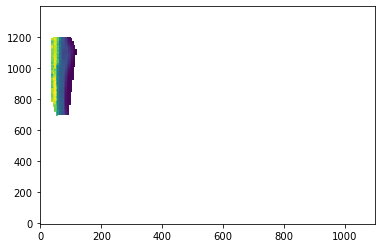

In [39]:
plt.pcolor(XX,YY,Z_dune,shading='auto')

One time step

In [40]:
pier_values0,pier_points0,Z_pier0=dut.interpolate_masked_lidar(Xpier,Ypier,topo_pier['elevation'][0],XX,YY,method=interp_method)

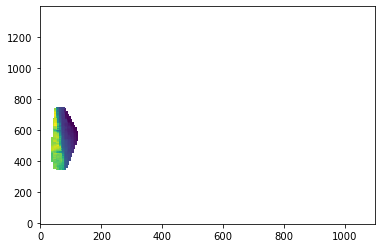

In [41]:
plt.pcolor(XX,YY,Z_pier0,shading='auto')

In [42]:
nt_pier=topo_pier['elevation'].shape[0]
pier_values,pier_points,Z_pier=dut.interpolate_masked_lidar(np.tile(Xpier,(nt_pier,1,1)),
                                                                np.tile(Ypier,(nt_pier,1,1)),topo_pier['elevation'],XX,YY,method='linear')

In [43]:
time_slice=0
all_points1,all_values1,Z_all1=dut.combine_and_interpolate_masked_lidar([Xdune,Xpier],[Ydune,Ypier],
                                                                 [topo_dune['elevation'][time_slice],
                                                                  topo_pier['elevation'][time_slice]],
                                                                 XX,YY,method='linear')

In [44]:
all_points,all_values,Z_all=dut.combine_and_interpolate_masked_lidar([np.tile(Xdune,(nt_dune,1,1)),
                                                                  np.tile(Xpier,(nt_pier,1,1))],
                                                                 [np.tile(Ydune,(nt_dune,1,1)),
                                                                  np.tile(Ypier,(nt_pier,1,1))],
                                                                 [topo_dune['elevation'],
                                                                  topo_pier['elevation']],
                                                                 XX,YY,method=interp_method)

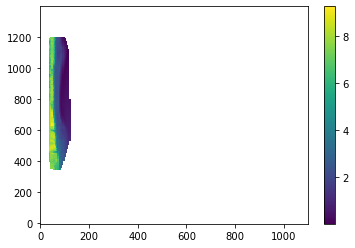

In [45]:
plt.pcolor(XX,YY,Z_all,shading='auto')
plt.colorbar()

In [46]:
interact(lambda ii: plt.plot(XX[ii,:],Z_all[ii,:],'b'),ii=(0,XX.shape[0]-1))

interactive(children=(IntSlider(value=139, description='ii', max=279), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(ii)>

## Extend merged topo in alongshore direction

In [47]:
Y_start_index,Y_end_index,Z_tmp=dut.extend_alongshore(XX,YY,Z_all)

In [48]:
interact(lambda ii: plt.plot(XX[ii,:],Z_tmp[ii,:],'o'),ii=(0,XX.shape[1]))

interactive(children=(IntSlider(value=110, description='ii', max=220), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(ii)>

(0.0, 200.0)

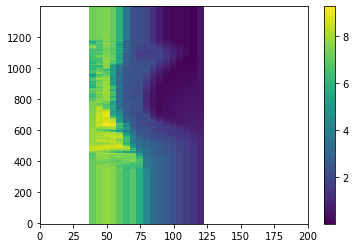

In [49]:
plt.pcolor(XX,YY,Z_tmp,shading='auto')
plt.colorbar()
plt.xlim([0,200])

## Load bathymetry transects

In [50]:
#times out
repull=False
if repull:
    bathy_data = go.getBathyTransectFromNC()#(profilenumbers=960)
    pickle.dump(bathy_data, open(os.path.join(datacache,"bathy_data_{0}.p".format(d1.date())), "wb" ) )


In [51]:
if 'bathy_data' not in globals():
    bathy_data=pickle.load(open(os.path.join(datacache,"bathy_data_{0}.p".format(d1.date())),"rb"))

In [52]:
bathy_data.keys()

dict_keys(['xFRF', 'yFRF', 'elevation', 'epochtime', 'time', 'lat', 'lon', 'northing', 'easting', 'profileNumber', 'surveyNumber', 'Ellipsoid'])

In [53]:
bathy_data['elevation'].shape,bathy_data['xFRF'].shape

((9115,), (9115,))

In [54]:
bathy_points=np.vstack((bathy_data['xFRF'],bathy_data['yFRF'])).T

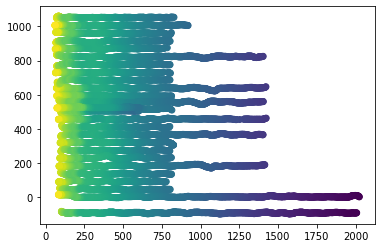

In [55]:
plt.scatter(bathy_points[:,0],bathy_points[:,1],c=bathy_data['elevation'])

In [56]:
points=np.vstack((all_points,bathy_points))
values=np.concatenate((all_values,bathy_data['elevation']))

In [57]:
## try to evaluate accuracy on a few points
check_points=np.empty(shape=(0,2))
check_values=np.empty(shape=(0,))
if check_error:
    check_points,check_values,new_points,new_values,check_inds=dut.extract_values_and_points(points,values,cross_check_fraction)
    orig_points=points.copy()
    orig_values=values.copy()
    points=new_points
    values=new_values


In [58]:
print('Total number of data points is {0}'.format(points.shape[0]))

Total number of data points is 78696


In [59]:
Z_interp=scipy.interpolate.griddata(points,values,(XX,YY),method=interp_method,fill_value=np.nan)

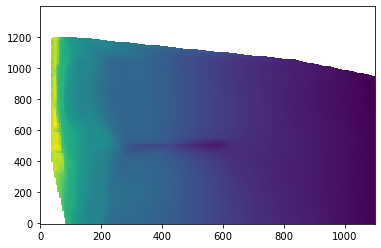

In [60]:
plt.pcolor(XX,YY,Z_interp,shading='auto')

In [61]:
Y_start_index,Y_end_index,Z_gridded=dut.extend_alongshore(XX,YY,Z_interp)

In [62]:
interact(lambda ii: plt.plot(XX[ii,:],Z_gridded[ii,:],'-'),ii=(0,XX.shape[1]))

interactive(children=(IntSlider(value=110, description='ii', max=220), Output()), _dom_classes=('widget-intera…

<function __main__.<lambda>(ii)>

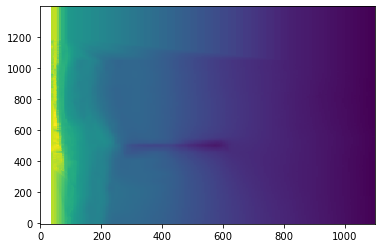

In [63]:
plt.pcolor(XX,YY,Z_gridded,shading='auto')

## Now try Gaussian Process Regression for fun

In [64]:
#RBF?
#GaussianProcessRegressor

In [89]:
# Instantiate a Gaussian Process model
length_scale,length_bounds=np.array([120.,120.]),np.array([1.0e0,1.5e3]) 
kernel = ConstKernel(1.0, (1e-3, 1e3)) * RBF(120., length_scale_bounds=length_bounds)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)


In [90]:
from numpy.random import default_rng
rng = default_rng()


In [91]:
gpr_fraction=100./values.size
gpr_fit_inds = rng.choice(values.size,size=int(gpr_fraction*values.size),replace=False)
gpr_values=values[gpr_fit_inds]
gpr_points=points[gpr_fit_inds]
print('mean of elevations used with GPR={0}'.format(gpr_values.mean()))

mean of elevations used with GPR=2.4550936356700426


In [92]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(gpr_points, gpr_values)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=120),
                         n_restarts_optimizer=2)

In [93]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
grid_points=np.array([XX.ravel(),YY.ravel()]).T
#ZZ_gpr, sigma_gpr = gp.predict(grid_points, return_std=True)
ZZ_gpr, sigma_gpr = gp.predict(gpr_points, return_std=True)


/Users/rdchlmwf/opt/anaconda3/envs/bathy/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [94]:
ZZ_gpr.min(),ZZ_gpr.max()

(-6.969999999957406, 8.18472623529123)

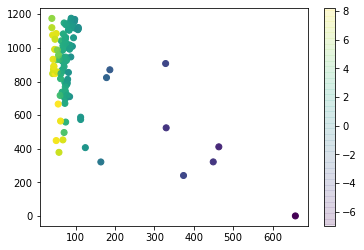

In [99]:
#plt.pcolor(XX,YY,ZZ_gpr.reshape(XX.shape))
plt.scatter(gpr_points[:,0],gpr_points[:,1],c=ZZ_gpr.flatten(),alpha=1)
plt.scatter(gpr_points[:,0],gpr_points[:,1],c=gpr_values,alpha=0.1)
plt.colorbar()


## Check the error

In [63]:
RMSE=None
if check_error:
    Z_check=scipy.interpolate.griddata(points,values,check_points,method=interp_method,fill_value=np.nan)
    diff=check_values-Z_check
    RMSE=np.sqrt(np.sum(diff**2)/float(diff.size))
    print('RMSE on {0}% random points is {1}'.format(cross_check_fraction,RMSE))


RMSE on 0.05% random points is 0.05714462421195177


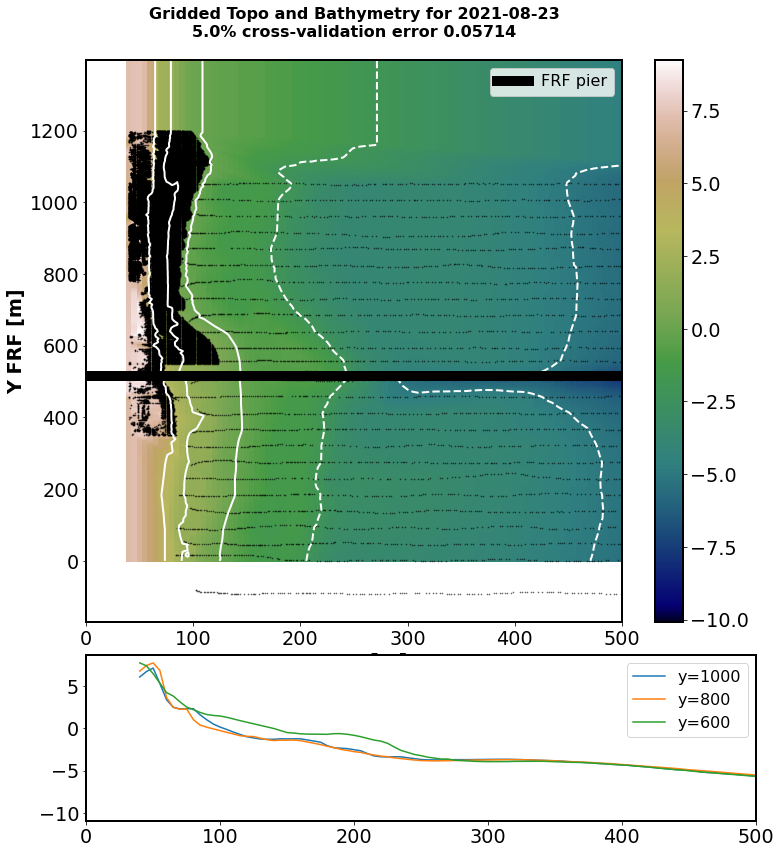

In [64]:
fig,plotname=dut.plot_bathy2d_with_obs(XX,YY,Z_gridded,points,cross_check_fraction,RMSE,d1.date(),plotdir=os.path.curdir,
                          bathyTime=None, topoDuneTime=None, topoPierTime=None)
fig

## Write out the gridded bathy

### setup coordinates

In [65]:
# get position stuff that will be constant for all surveys!!!
xFRFi_vecN = XX.reshape((1, XX.shape[0] * XX.shape[1]))[0]
yFRFi_vecN = YY.reshape((1, YY.shape[0] * YY.shape[1]))[0]
# convert FRF coords to lat/lon
test = geoprocess.FRF2ncsp(xFRFi_vecN, yFRFi_vecN)
# go through stateplane to avoid FRFcoords trying to guess the input coordinate systems
temp = geoprocess.ncsp2LatLon(test['StateplaneE'], test['StateplaneN'])
lat_vec = temp['lat']
lon_vec = temp['lon']
E_vec = test['StateplaneE']
N_vec = test['StateplaneN']

latitude = lat_vec.reshape(XX.shape[0], XX.shape[1])
longitude= lon_vec.reshape(XX.shape[0], XX.shape[1])
easting  = E_vec.reshape(XX.shape[0], XX.shape[1])
northing = N_vec.reshape(XX.shape[0], XX.shape[1])

xFRF = XX[0, :]
yFRF = YY[:, 1]


In [66]:
outfile='IntegratedBathyTopo-{0}.nc'.format(d1.date())

In [ ]:
nc_dict={}
nc_dict['elevation'] = Z_gridded[np.newaxis,:,:]
nc_dict['xFRF'] = xFRF
nc_dict['yFRF'] = yFRF
nc_dict['latitude'] = latitude
nc_dict['longitude'] = longitude
nc_dict['northing'] = northing
nc_dict['easting'] = easting
nc_dict['updateTime'] = np.ones_like(nc_dict['elevation'])*d1.timestamp()
nc_dict['time'] = d1.timestamp()
nc_dict['survey_time'] = np.nanmean(bathy_data['epochtime'])


In [ ]:
py2netCDF.makenc_generic(outfile,global_yaml,var_yaml,nc_dict)

In [ ]:
foo=netCDF4.Dataset(outfile)

In [ ]:
foo

In [ ]:
np.nanmax(np.absolute(foo['elevation'][0]-Z_gridded))

In [ ]:
foo['survey_time'][:]

In [ ]:
tmpx,tmpy=np.meshgrid(foo['xFRF'],foo['yFRF'])
tmpz=foo['elevation'][0]


In [ ]:
foo.close()

In [ ]:
plt.pcolor(tmpx,tmpy,tmpz,shading='auto')